In [1]:
library(argparse)
library(Matrix)
library(mvtnorm)
library(ggplot2)
library(hexbin)
library(rhdf5)
library(BoutrosLab.plotsing.general)
library(sn)

Loading required package: lattice

Loading required package: latticeExtra


Attaching package: ‘latticeExtra’


The following object is masked from ‘package:ggplot2’:

    layer


Loading required package: cluster

Loading required package: grid


Attaching package: ‘BoutrosLab.plotting.general’


The following object is masked from ‘package:stats’:

    dist


Loading required package: stats4


Attaching package: ‘sn’


The following object is masked from ‘package:stats’:

    sd




# Define simulation params

In [2]:
ngenes = 13000
ntargets = 1000
ncells = 50000
d = 2
lambda = 15
guide_disp = c(10, 100)

# Simulate baselines

In [3]:
baselines <- rnorm(ngenes, mean = 2.24, sd = 1.8)

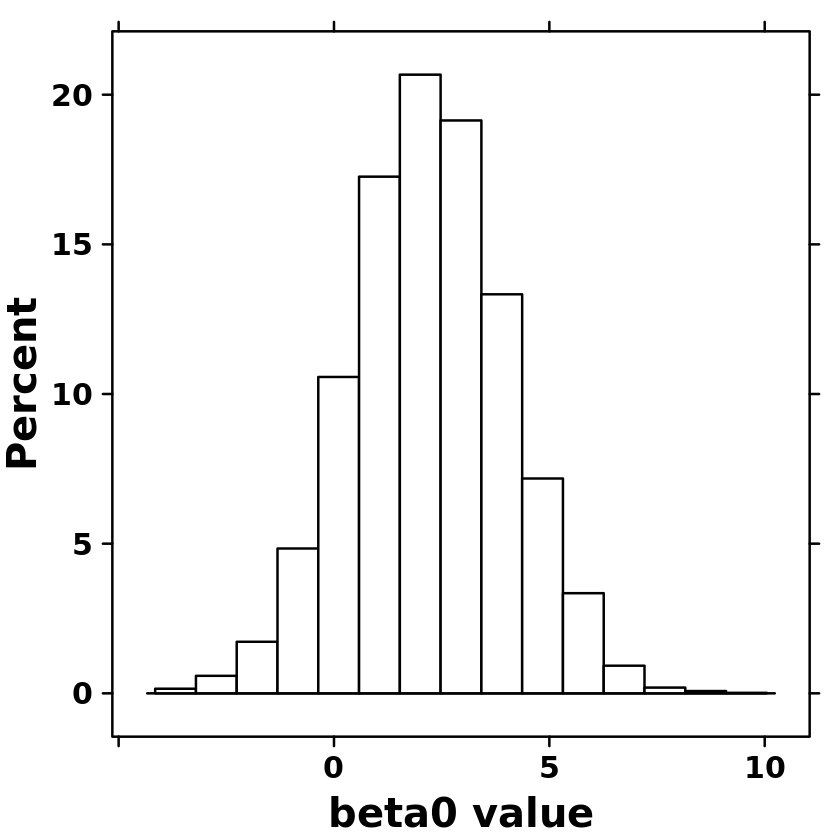

In [5]:
create.histogram(
    x = baselines,
#     filename = file.path(args$out, 'beta0_distribution.tiff'),
    resolution = 200,
    xlab.label = 'beta0 value',
    ylab.label = 'Percent'
)

# Assign guides to cells 

In [6]:
# compute number of guides
num.guides = d * ntargets

# initialize one hot encoding
onehot.guides <- matrix(0, ncells, num.guides)

# get nr of guides per cell
guides.per.cell <- rpois(ncells, lambda)

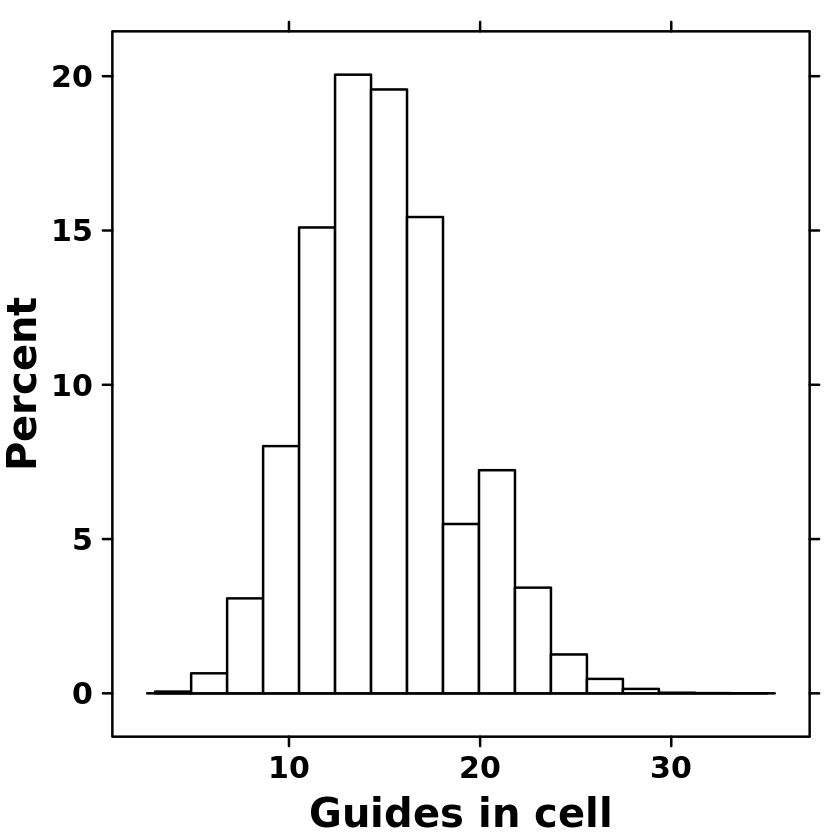

In [7]:
# plot nr of guides per cell
create.histogram(
    x = guides.per.cell,
#     filename = file.path(args$out, 'guides_per_cell_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Guides in cell',
    ylab.label = 'Percent'
)

In [8]:
# assign guides to each cell
guides.idx.list <- sapply(guides.per.cell, function(x) {
    sample(1:num.guides, x, replace = FALSE)
})

for (i in 1:ncells) {
    guides.idx <- guides.idx.list[[i]]
    onehot.guides[i, guides.idx] <- 1
}

In [9]:
# assign guide efficiencies to guides in library
efficiencies <- rbeta(num.guides, 6,3)

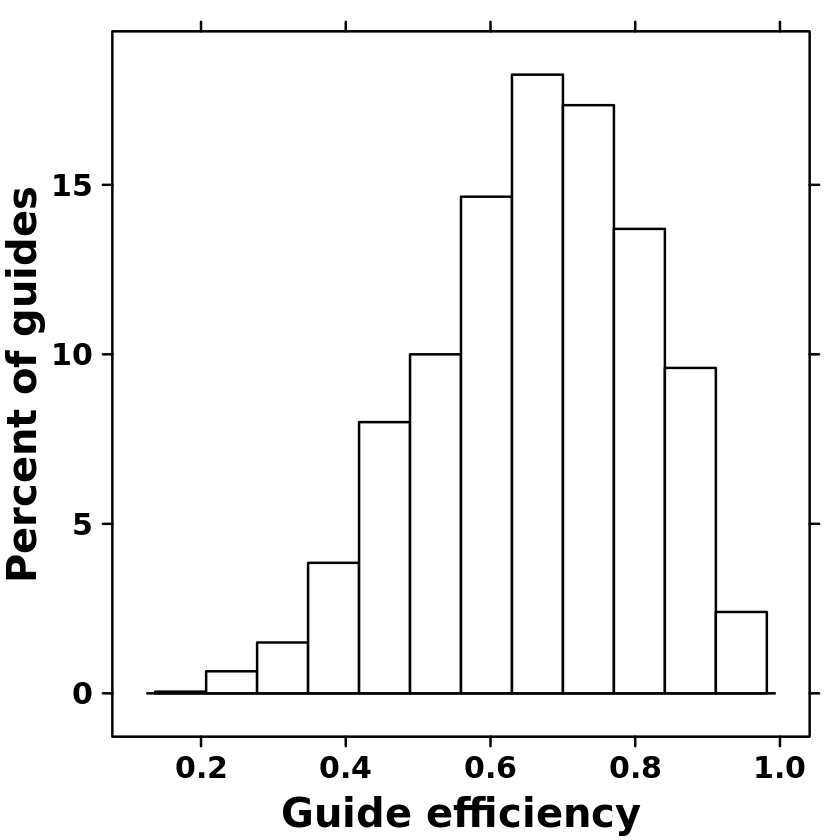

In [10]:
# plot guide efficiencies
create.histogram(
    x = efficiencies,
#     filename = file.path(args$out, 'guide_efficiency_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Guide efficiency',
    ylab.label = 'Percent of guides'
)

# Simulate estimated guide efficiencies

In [11]:
est.efficiencies.list <- list()
disps.list <- list()
i <- 1

if (!is.null(guide_disp)) {
    print("simulating estimated guide efficiency values")

    for (gd in guide_disp) {
        cat(sprintf("D=%d\n",gd))
        est.eff <- rbeta(num.guides, efficiencies*gd, efficiencies*gd)  
        est.efficiencies.list[[i]] <- est.eff 
        disps.list[[i]] <- rep(gd, num.guides)
        # writeLines(est.efficiencies.list, file.path(args$out, sprintf("est_efficiencies_D%d.txt", d)))

#         png(file.path(args$out, sprintf("hist_est_guide_efficiences_D%d.png", d)))
#         hist(est.eff, main = sprintf("Histogram of estimated guide efficiencies, D=%d", d))
#         dev.off()

        i <- i + 1
    }
} 

est.efficiencies.df <- data.frame(est.efficiency = do.call(c, est.efficiencies.list), 
                                    D = do.call(c, disps.list))


[1] "simulating estimated guide efficiency values"
D=10
D=100


In [12]:
head(est.efficiencies.df)

,est.efficiency,D
,<dbl>,<dbl>
1,0.4435802,10
2,0.4705297,10
3,0.4774509,10
4,0.4581876,10
5,0.4053587,10
6,0.4621047,10


In [16]:
est.efficiencies.df$D <- as.factor(est.efficiencies.df$D)
# table(est.efficiencies.df$D)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



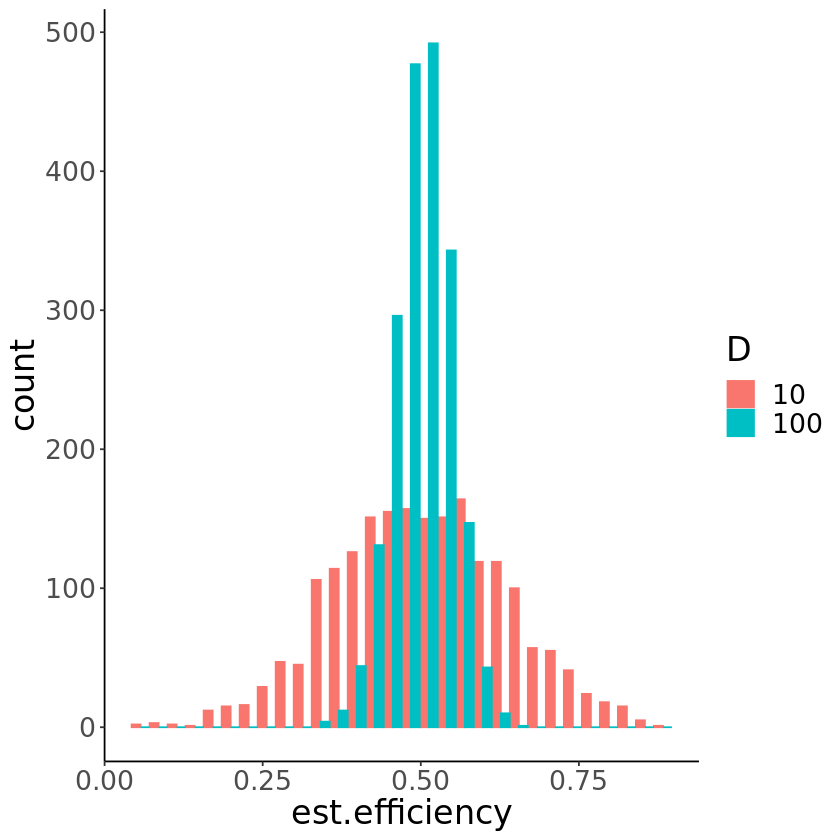

In [20]:
ggplot(est.efficiencies.df, 
       aes(x = est.efficiency, fill = D, color = D)) + 
geom_histogram(position = "dodge") + theme_classic() + theme(text = element_text(size = 20))

# Assign target genes to gRNAs

In [21]:
target.genes <- sample(1:ngenes, ntargets, replace = FALSE)

# create guide gene map which has the gene ID of the enhancer that gRNA is targeting
guide.gene.map <- rep(target.genes, d)

# get effect sizes of each enhancer on its target gene (beta1)
effect.sizes <- -1 * (rgamma(ntargets, shape = 6, scale = 0.5))


# Save guides metadata to file

In [25]:
guides.metadata <- data.frame(guide.gene.map, efficiencies, rep(effect.sizes, 2))
colnames(guides.metadata) <- c("target.gene", "efficiency", "effect.size")


In [26]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,558,0.9289043,-1.481992
2,9280,0.4309214,-2.640257
3,4419,0.7546815,-4.220039
4,5652,0.5852424,-3.380796
5,10595,0.5833921,-2.070548
6,4159,0.6217688,-4.310822


# Simulate $\beta_1$ values

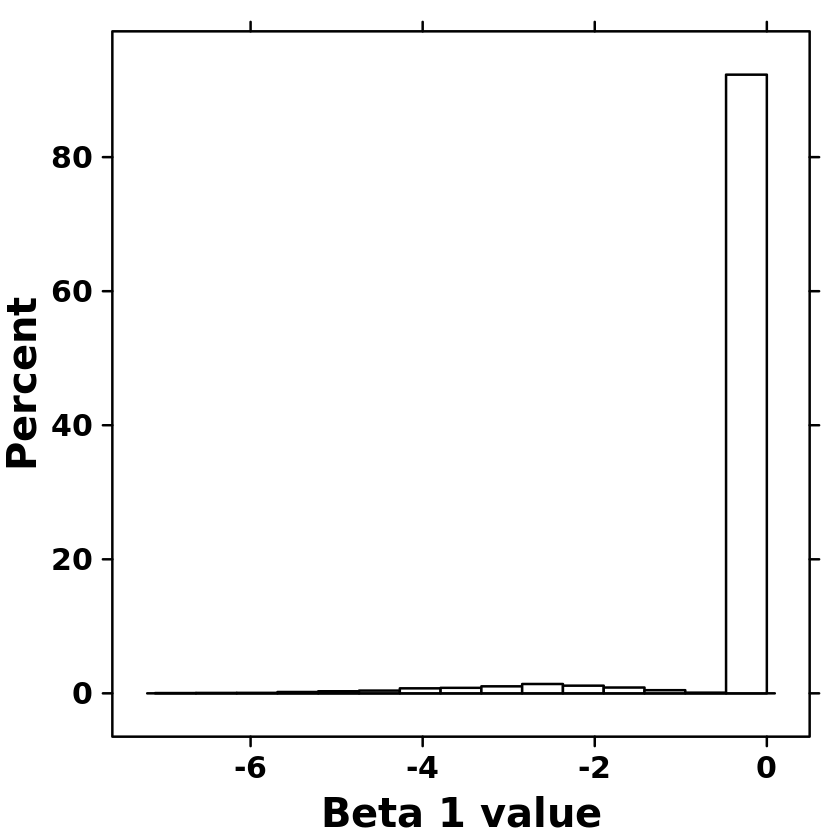

In [24]:
beta1 <- rep(0, ngenes) # initialize vector of zeros

for (i in 1:length(target.genes)) {
    # for each target gene, update its position in beta1 to effect size
    target <- target.genes[i]
    beta1[target] <- effect.sizes[i]
}

# plot beta1 values (expected pileup at zero)
create.histogram(
    x = beta1,
#     filename = file.path(args$out, 'beta1_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Beta 1 value',
    ylab.label = 'Percent'
)


# Simulate S, G2M scores

In [27]:
# load cell cycle scores
covars <- h5read('/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5','covariates')
emp.s <- covars$s.score
emp.g2m <- covars$g2m.score

# define optimization fxn for normal
optim_norm <- function(par, data) {
    -sum(dnorm(data, mean = par[1], sd = par[2], log = TRUE))
}

# fit normal distribution to observed S scores
s.score.fit <- optim(c(1,1), optim_norm, data = emp.s, lower = c(-Inf, 1e-10), upper = c(Inf, Inf), method = "L-BFGS-B")

# simulate S scores
s.scores <- rnorm(ncells, mean = s.score.fit$par[1], sd = s.score.fit$par[2])

# fit skew normal to observed G2M scores
g2m.fit <- selm(X ~ 1, data=data.frame(X=emp.g2m))
extractSECdistr(g2m.fit)

# simulate G2M scores (hardcoded based on values in notebook)
g2m.scores <- rsn(n=ncells, xi=-0.2556359, omega=0.3124325, alpha=6.2932919, tau=0, dp=NULL)


Probability distribution of variable 'Fitted SEC distribution of g2m.fit'
Skew-elliptically contoured distribution of univariate family SN 
Direct parameters:
        xi      omega      alpha 
-0.2556359  0.3124325  6.2932919 

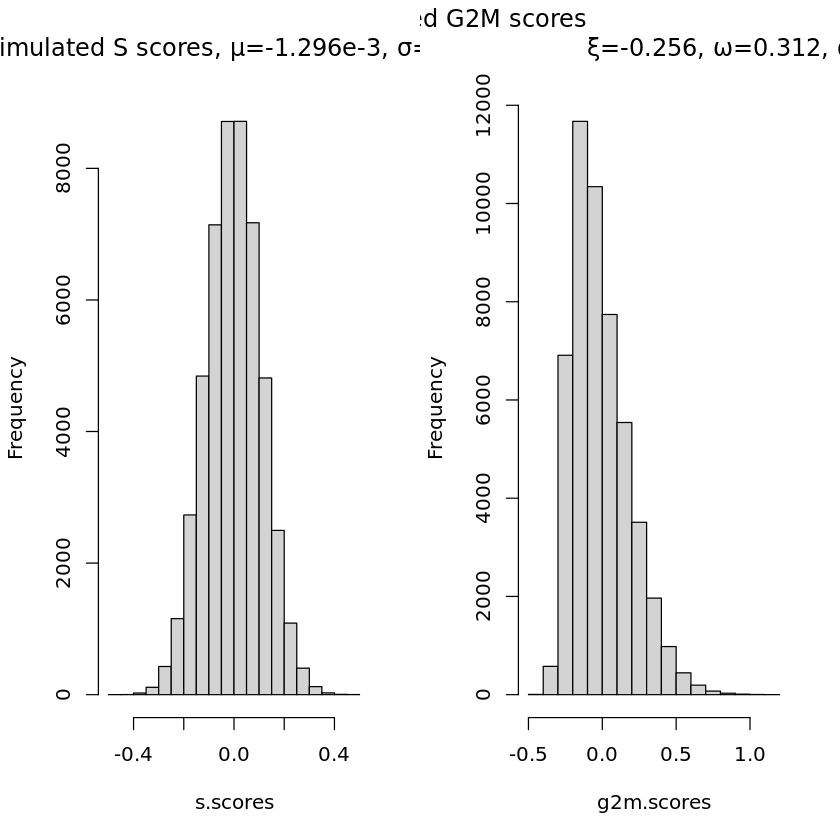

In [28]:
par(mfrow = c(1,2))

hist(s.scores, 
    main = expression(
        paste("Simulated S scores, ", 
            mu, "=-1.296e-3, ", 
            sigma, "=0.11")))

hist(g2m.scores,
    main = expression(
        paste("Simulated G2M scores\n", 
            xi, "=-0.256, ", 
            omega, "=0.312, ", 
            alpha, "=6.29, ", 
            tau, "=0")))

In [29]:
cell.cycle.scores <- data.frame(s.scores, g2m.scores)


# Simulate $\beta_2,\beta_3$

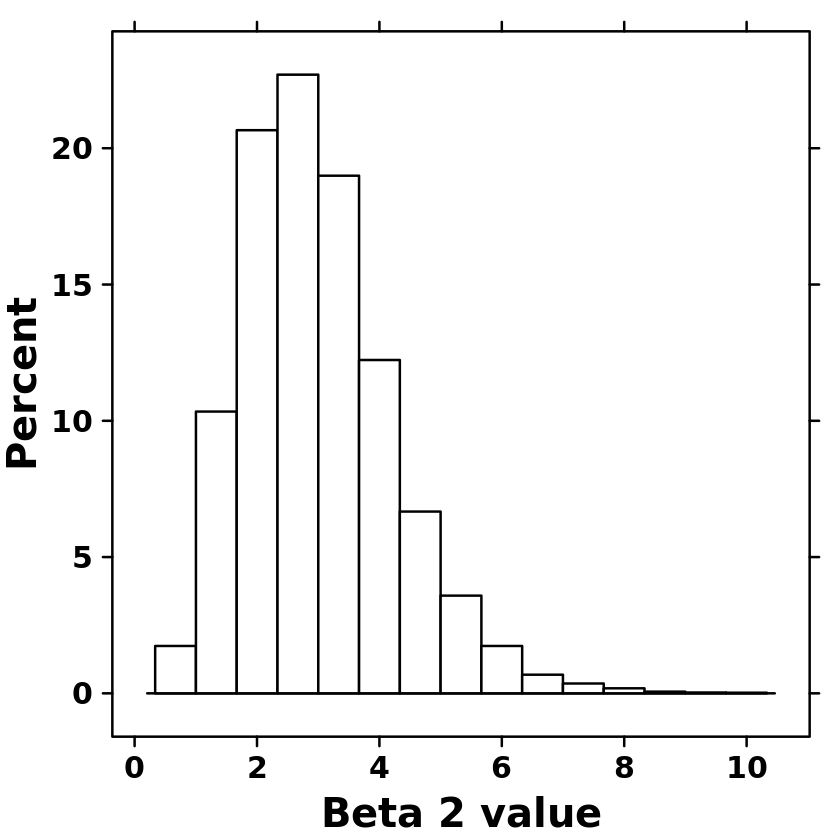

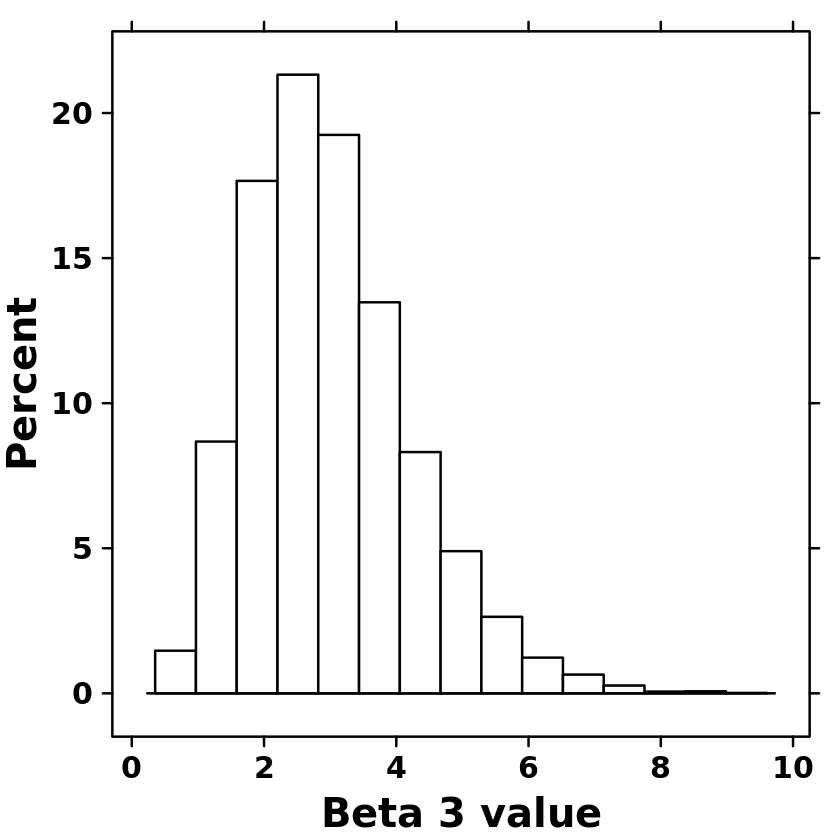

In [30]:
beta2 <- rgamma(ngenes, shape = 6, scale = 0.5)
beta3 <- rgamma(ngenes, shape = 6, scale = 0.5)

# plot beta2
create.histogram(
    x = beta2,
#     filename = file.path(args$out, 'beta2_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Beta 2 value',
    ylab.label = 'Percent'
)

# plot beta3
create.histogram(
    x = beta3,
#     filename = file.path(args$out, 'beta3_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Beta 3 value',
    ylab.label = 'Percent'
)

# Simulate $\beta_4,X_4$ (percent.mito)

In [31]:
percent.mito <- rbeta(ncells, shape1 = 3.3, shape2 = 81.48)

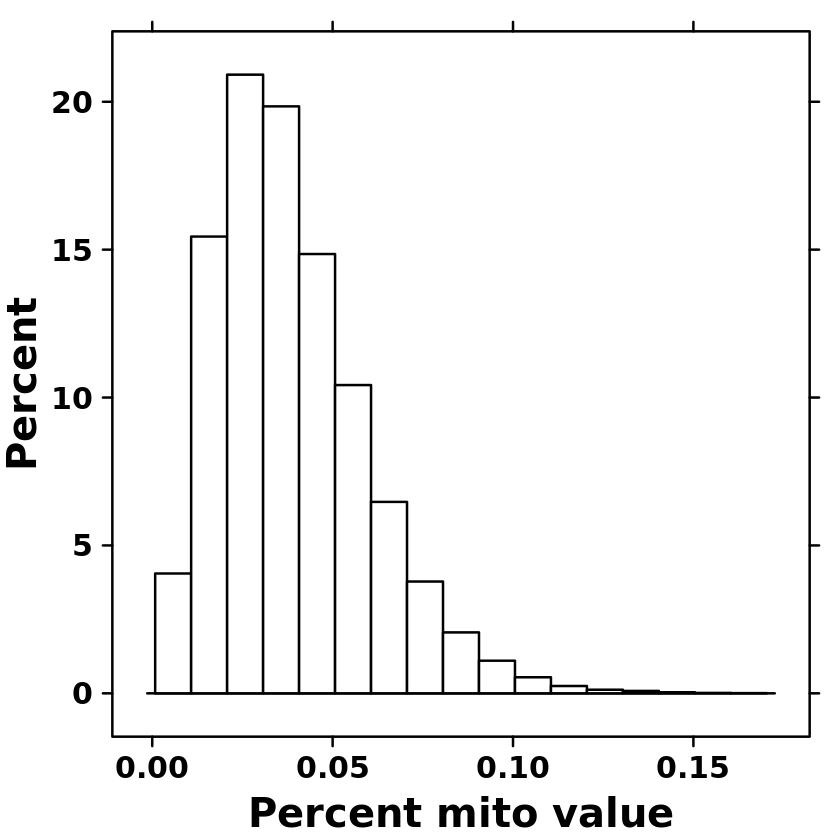

In [32]:
# plot distribution of percent mito
create.histogram(
    x = percent.mito,
#     filename = file.path(args$out, 'percent_mito_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Percent mito value',
    ylab.label = 'Percent'
)

In [33]:
beta4 <- rgamma(ngenes , shape = 6 , scale = 0.5)

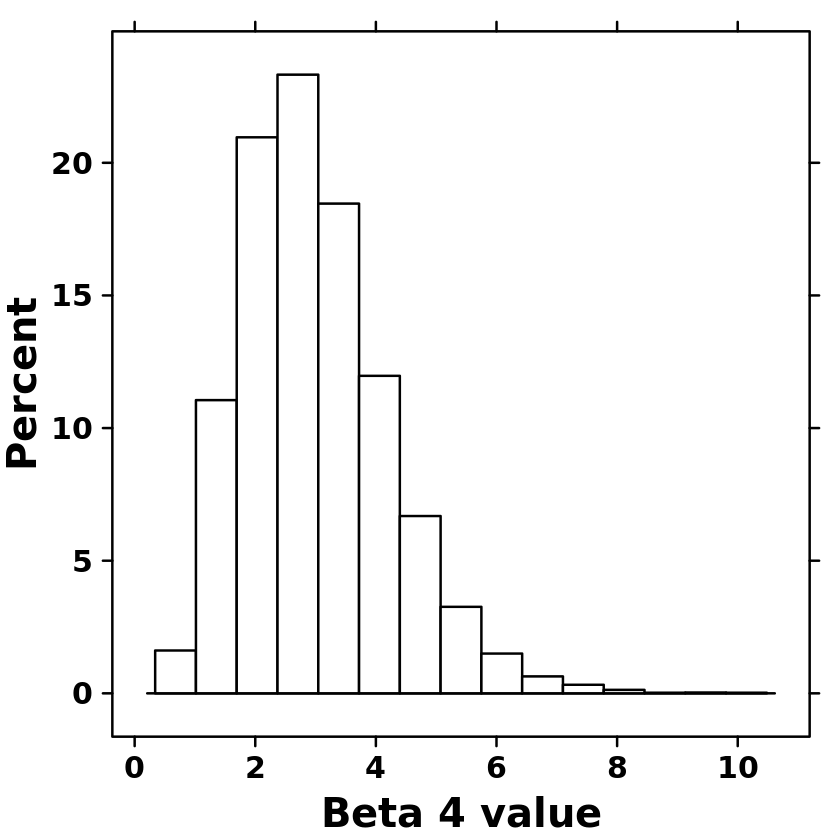

In [34]:
# plot
create.histogram(
    x = beta4,
#     filename = file.path(args$out, 'beta4_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Beta 4 value',
    ylab.label = 'Percent'
)

In [35]:
percent.mito.df <- data.frame(percent.mito)


# Write coeffs to table

In [36]:
coeffs <- data.frame(baselines, beta1, beta2, beta3, beta4)


# Simulate scaling factors

In [37]:
# simulate total counts per cell
t.vec <- rpois(ncells, 50000)

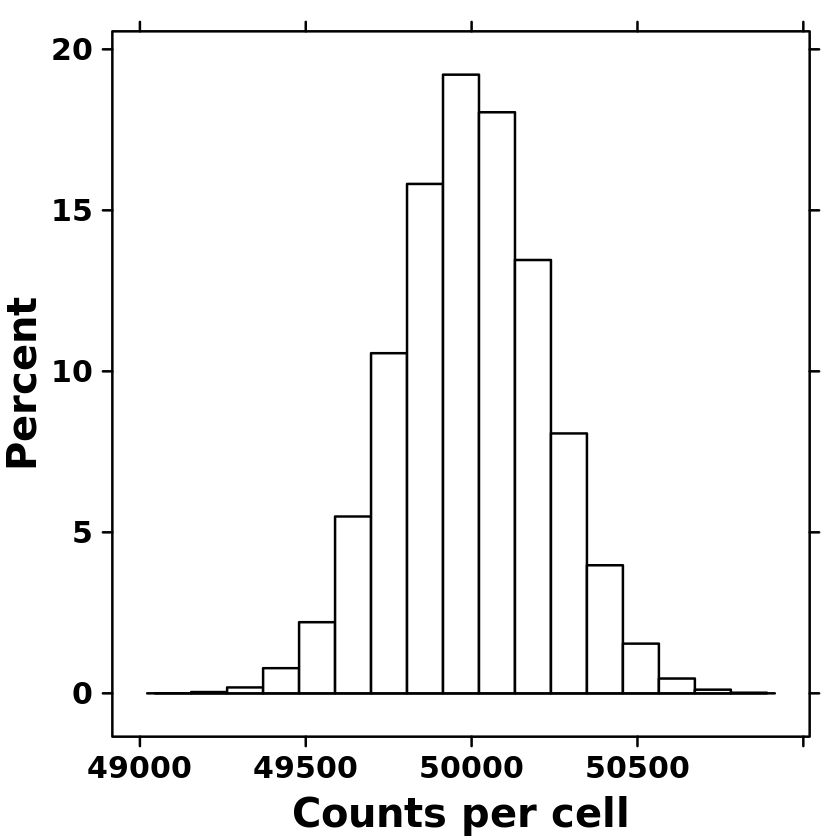

In [38]:
# plot total counts per cell
create.histogram(
    x = t.vec,
#     filename = file.path(args$out, 'counts_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Counts per cell',
    ylab.label = 'Percent'
)

In [39]:

# get scaling factors
scaling.factors <- t.vec / 1e6


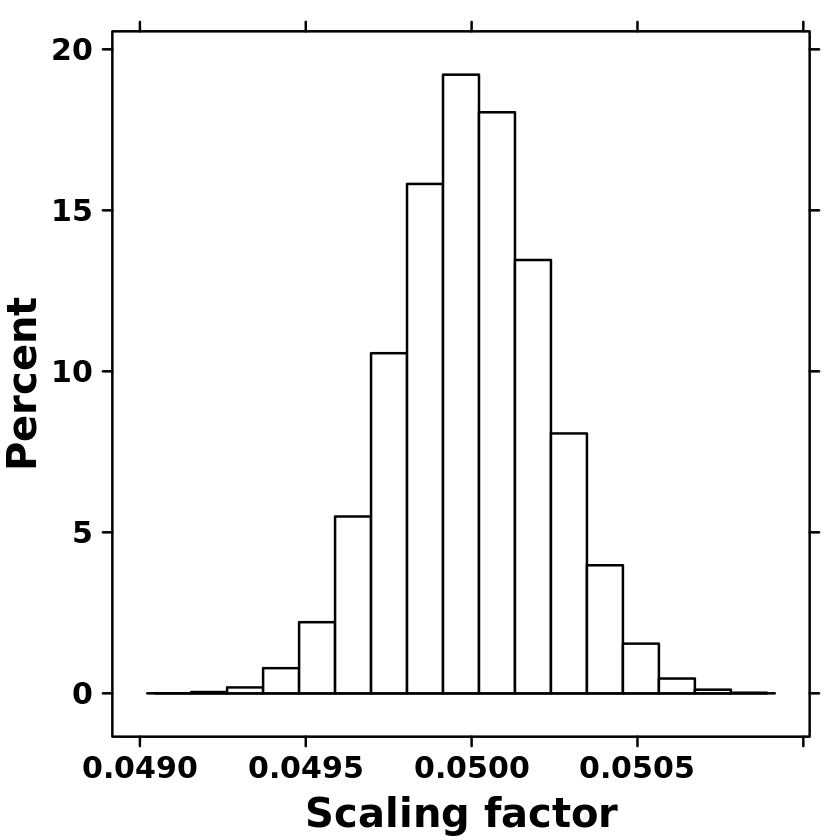

In [40]:
# plot distribution of scaling factors
create.histogram(
    x = scaling.factors,
#     filename = file.path(args$out, 'scaling_factor_distribution.tiff'),
    resolution = 200,
    xlab.label = 'Scaling factor',
    ylab.label = 'Percent'

)


# Define function for calculating $X_1$

In [75]:
combined_prob <- function(cell, gene, guides, verbose = FALSE) {
    # calculate X1 as a combined probability 
    if (verbose) {
        cat(sprintf("calculating value of X1 for gene %d in cell %d\n", gene, cell))
    }

    # identify which gRNAs in our design target this gene
#     guides.for.gene <- which(guide.gene.map==gene)
    
    prod.terms <- numeric(length(guides))
    for (i in 1:length(guides)) {
        cat(sprintf("i = %d\n", i))
        if (onehot.guides[cell,guides[i]]!=0) {
        # if (sum(h5read(args$h5, "guides/one_hot", index = list(cell, guides[i])))!=0) {
            prod.terms[i] <- efficiencies[guides[i]]
        }
    }
    x1 <- 1-prod(1-prod.terms)
    return(x1)
}


# Simulate counts matrix

In [76]:
# initialize counts matrix
sim.counts <-  matrix(0, ngenes, ncells)

# initialize matrix of x1 values (different set of values for each gene)
x1.mtx <- matrix(0, ngenes, ncells)

# # initialize matrices for storing values of linear predictor and mu
# lp.mtx <- matrix(0, ngenes, ncells)
# mu.mtx <- matrix(0, ngenes, ncells)


In [161]:
# populate counts mtx by gene (by row)
for (gene in guides.metadata$target.gene[1:10]) {
    cat(sprintf("simulating counts for gene %d\n", gene))

    # get coeffs
    b0 <- baselines[gene]
    b1 <- beta1[gene]
    b2 <- beta2[gene]
    b3 <- beta3[gene]
    b4 <- beta4[gene]
    
    # initialize x1 as vector of zeros (assume it is not affected by any gRNAs in library)
    x1 <- numeric(ncells)
    
    # check if enhancer of gene is targeted by any gRNAs
    if (gene %in% target.genes) {
        guides.for.gene <- which(guide.gene.map==gene)
        cat(sprintf("gene %d is a targeting gene\n", gene))
        temp.mtx <- t(efficiencies[guides.for.gene]*t(onehot.guides[,guides.for.gene]))
        x1 <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
#         for (i in 1:ncells) {
#             x1[i] <- combined_prob(i, gene, guides.for.gene)
#         }
    }
    
    print(sum(x1))

    x1.mtx[gene,] <- x1

#     # get cell cycle scores
#     x2 <- s.scores
#     x3 <- g2m.scores
#     x4 <- percent.mito
    
#     # calculate values of mu
#     lp.vec <- b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + log(scaling.factors)
#     lp.mtx[gene,] <- lp.vec
#     mu.vec <- exp(lp.vec)
#     mu.mtx[gene,] <- mu.vec
    
#     # use rnbinom to generate counts of each cell for this gene and update counts matrix
# #     counts <- sapply(mu.vec, function(x) {rnbinom(1, mu = x, size = 1.5)})
#     counts <- rnbinom(length(mu.vec), mu = mu.vec, size = 1.5)
#     sim.counts[gene,] <- counts
}

simulating counts for gene 558
gene 558 is a targeting gene
[1] 553.4537
simulating counts for gene 9280
gene 9280 is a targeting gene
[1] 408.8865
simulating counts for gene 4419
gene 4419 is a targeting gene
[1] 553.6987
simulating counts for gene 5652
gene 5652 is a targeting gene
[1] 514.6863
simulating counts for gene 10595
gene 10595 is a targeting gene
[1] 594.1464
simulating counts for gene 4159
gene 4159 is a targeting gene
[1] 521.1724
simulating counts for gene 4304
gene 4304 is a targeting gene
[1] 505.757
simulating counts for gene 10224
gene 10224 is a targeting gene
[1] 513.9474
simulating counts for gene 11217
gene 11217 is a targeting gene
[1] 466.1922
simulating counts for gene 1571
gene 1571 is a targeting gene
[1] 538.2925


In [164]:
test.gene <- guides.metadata$target.gene[1]
test.gene

[1] 558

In [165]:
# get coeffs
b0 <- baselines[gene]
b1 <- beta1[gene]
b2 <- beta2[gene]
b3 <- beta3[gene]
b4 <- beta4[gene]

In [166]:
b0
b1
b2
b3
b4

[1] -0.3482628

[1] -2.695366

[1] 4.00808

[1] 8.155002

[1] 4.825392

In [167]:
# initialize x1 as vector of zeros (assume it is not affected by any gRNAs in library)
x1 <- numeric(ncells)


In [168]:
head(x1)

[1] 0 0 0 0 0 0

In [84]:
# check if enhancer of gene is targeted by any gRNAs
if (test.gene %in% target.genes) {
    cat(sprintf("gene %d is a targeting gene\n", test.gene))
    guides.for.gene <- which(guide.gene.map==test.gene)
    for (i in 1:ncells) {
        x1[i] <- combined_prob(i, gene, guides.for.gene)
    }
}

gene 558 is a targeting gene
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2
i = 1
i = 2

In [85]:
print(sum(x1))

[1] 553.4537


In [89]:
onehot.guides[,guides.for.gene]

0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0


In [170]:
guides.for.gene <- which(guide.gene.map==test.gene)

In [171]:
sum(onehot.guides[,1]*efficiencies[guides.for.gene[1]])

[1] 326.0454

In [172]:
sum(onehot.guides[,guides.for.gene[2]]*efficiencies[guides.for.gene[2]])

[1] 227.9376

In [173]:
temp.mtx <- t(efficiencies[guides.for.gene]*t(onehot.guides[,guides.for.gene]))
colSums(temp.mtx)

[1] 326.0454 227.9376

In [174]:
sum(apply(temp.mtx, 1, function(x) {1-prod(1-x)}))

[1] 553.4537

In [175]:
colSums(onehot.guides[,guides.for.gene] %*% diag(efficiencies[guides.for.gene]))

[1] 326.0454 227.9376

In [176]:
system.time(t(efficiencies[guides.for.gene]*t(onehot.guides[,guides.for.gene])))

   user  system elapsed 
  0.001   0.000   0.001 

In [177]:
system.time(onehot.guides[,guides.for.gene] %*% diag(efficiencies[guides.for.gene]))

   user  system elapsed 
  0.001   0.000   0.002 